# UPF 


## Quick Start

### Create drone simulation


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Code.Simulation.BiRobotMovement import drone_flight, run_simulation, random_movements_host_random_movements_connected
from Code.UtilityCode.utility_fuctions import sphericalToCartesian

#set parameters
simulation_time = 300
odom_frequency = 10.
odom_time_step = 1/odom_frequency
uwb_frequency = 10.
factor = odom_frequency/uwb_frequency
simulation_time_steps = int(simulation_time / odom_time_step) 

max_range = 5
sigma_v =  0.01
sigma_w = 0.01
sigma_uwb = 0.1


# Created randomised starting positions.
x_drone_0 = sphericalToCartesian(np.array([np.random.uniform(0,max_range), np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi)]))
pose_drone_0 = np.concatenate((x_drone_0, np.array([np.random.uniform(0, 2*np.pi)])))
x_drone_1 = sphericalToCartesian(np.array([np.random.uniform(0,max_range), np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi)]))
pose_drone_1 = np.concatenate((x_drone_1, np.array([np.random.uniform(0, 2*np.pi)])))
print(pose_drone_0, pose_drone_1)

drone_0 = drone_flight(pose_drone_0, sigma_dv=sigma_v, sigma_dw=sigma_w, max_range=max_range,
                          origin_bool=True, simulation_time_step=odom_time_step)
drone_1 = drone_flight(pose_drone_1, sigma_dv=sigma_v, sigma_dw=sigma_w, max_range=max_range,
                         origin_bool=True, simulation_time_step=odom_time_step)

run_simulation(simulation_time_steps, drone_0, drone_1,
                       random_movements_host_random_movements_connected)


distance = np.linalg.norm(drone_0.x_start - drone_1.x_start)
startMeasurement = distance + np.random.randn(1) * sigma_uwb

[-1.63610475  1.76420753  8.89632332  3.31113948] [-3.53666078 -2.76296964  8.24270896  6.22298628]
{'i': 2999}


### Plotting the simulated trajectory

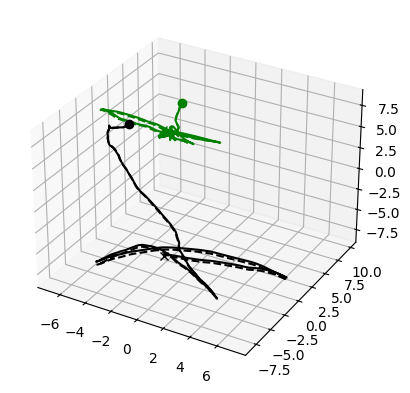

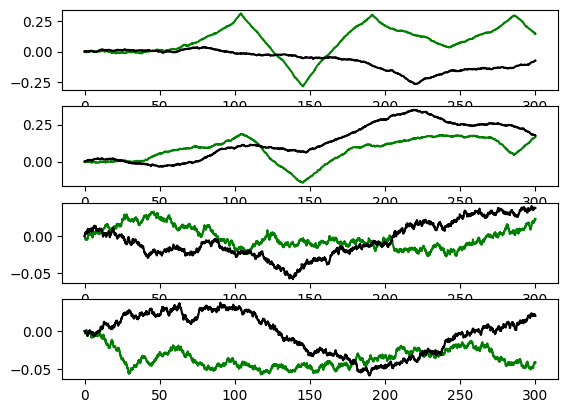

In [8]:
ax = plt.figure().add_subplot(projection='3d')
drone_0.plot_trajectory(ax =ax, color = "green")
drone_0.plot_slam_position(ax =ax, color = "green", linestyle="--")
drone_1.plot_trajectory(ax =ax, color = "black")
drone_1.plot_slam_position(ax =ax, color = "black", linestyle="--")

ax = drone_0.plot_slam_error(annotation="Drone_0", color ="green")
ax = drone_1.plot_slam_error(annotation="Drone_1", ax=ax, color="black")
#TODO: add legends
plt.show()

### The UPF
#### Setting up the UPF

In [12]:
from Code.ParticleFilter.ConnectedAgentClass import UPFConnectedAgent
from Code.DataLoggers.ConnectedAgent_DataLogger import UPFConnectedAgentDataLogger

upf0 = UPFConnectedAgent(id="drone_1", x_ha_0=pose_drone_0, drift_correction_bool=True, resample_factor=0.1)
upf0.set_ukf_parameters(kappa=-1, alpha=1, beta=2)
upf0.split_sphere_in_equal_areas(r=startMeasurement[0], sigma_uwb= sigma_uwb, n_azimuth=4, n_altitude=3, n_heading=4)

dl0 = UPFConnectedAgentDataLogger(drone_0, drone_1, upf0)

#### Running the UPF simulation

Simulation step:  1  / 3000
Simulation step:  2  / 3000
Simulation step:  3  / 3000
Simulation step:  4  / 3000
Simulation step:  5  / 3000
Simulation step:  6  / 3000
Simulation step:  7  / 3000
Simulation step:  8  / 3000
Simulation step:  9  / 3000
Simulation step:  10  / 3000
Simulation step:  11  / 3000
Simulation step:  12  / 3000
Simulation step:  13  / 3000
Simulation step:  14  / 3000
Simulation step:  15  / 3000
Simulation step:  16  / 3000
Simulation step:  17  / 3000
Simulation step:  18  / 3000
Simulation step:  19  / 3000
Simulation step:  20  / 3000
Simulation step:  21  / 3000
Simulation step:  22  / 3000
Simulation step:  23  / 3000
Simulation step:  24  / 3000
Simulation step:  25  / 3000
Simulation step:  26  / 3000
Simulation step:  27  / 3000
Simulation step:  28  / 3000
Simulation step:  29  / 3000
Simulation step:  30  / 3000
Simulation step:  31  / 3000
Simulation step:  32  / 3000
Simulation step:  33  / 3000
Simulation step:  34  / 3000
Simulation step:  35  /

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Simulation step:  2993  / 3000
Simulation step:  2994  / 3000
Simulation step:  2995  / 3000
Simulation step:  2996  / 3000
Simulation step:  2997  / 3000
Simulation step:  2998  / 3000
Simulation step:  2999  / 3000


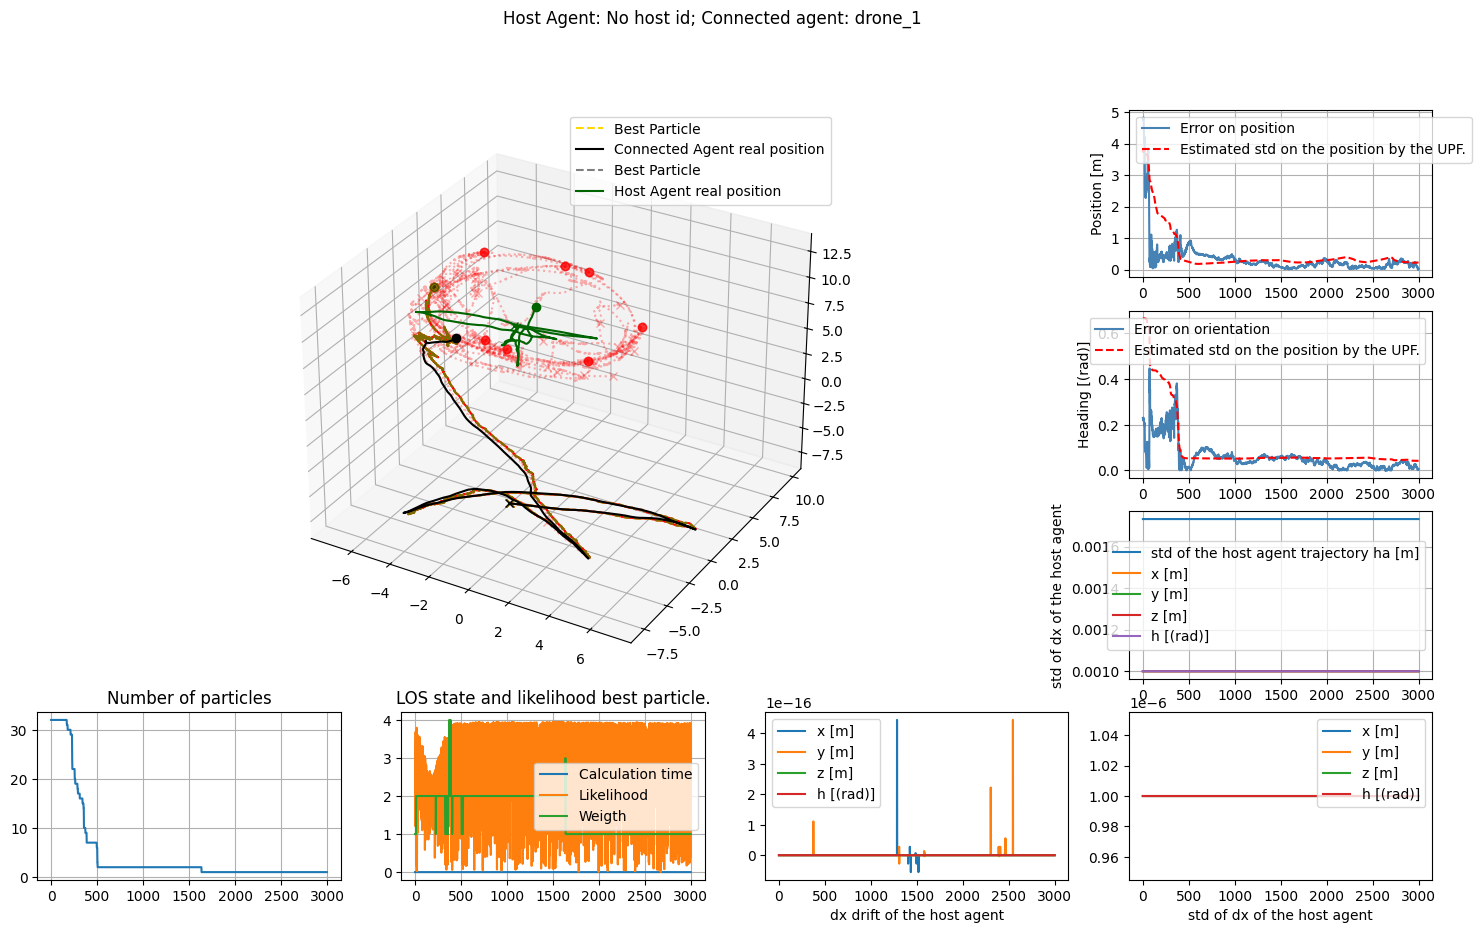

In [13]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps):
    print("Simulation step: ", i, " /", simulation_time_steps)
    d_dx_0 = np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    upf0.ha.predict(d_dx_0, drone_0.q)
    q_0 = q_0 + get_4d_rot_matrix(drone_0.h_slam[i]) @ drone_0.q @ get_4d_rot_matrix(drone_0.h_slam[i]).T
    
    d_dx_1 = np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    f = get_4d_rot_matrix(d_dx_1[-1])
    dx_1 = dx_1 + f @ d_dx_1
    q_1 = q_1 + f @ drone_1.q @ f.T
    if i % factor == 0:
        distance = np.linalg.norm(drone_1.x_real[i] - drone_0.x_real[i])
        uwb_measurement = distance + np.random.randn(1)[0] * sigma_uwb
        # uwb_measurement, los_state = nlos_function(int(i / self.factor), uwb_measurement)
        x_ha = drone_0.x_slam[i]
        h_ha = drone_0.h_slam[i]
        x_ha = np.concatenate([x_ha, np.array([h_ha])])

        upf0.ha.update(x_ha, q_0)
        upf0.run_model(dx_1, uwb_measurement, q_ca=q_1)

        dl0.log_data(i)
        
        

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        q_0 = np.zeros((4, 4))
        upf0.ha.reset_integration()
 
#TODO: add legend       
dl0.plot_self()
plt.pause(0.01)
plt.close()

### NLS 
#### Setting up the NLS

In [11]:
from Code.BaseLines.NLS import NLS
from Code.DataLoggers.NLS_DataLogger import NLSDataLogger

agents = {"drone_0": drone_0, "drone_1": drone_1}
NLS = NLS(agents, horizon = 10, sigma_uwb=sigma_uwb)
sampling_factor = 10
nls_logger = NLSDataLogger(NLS)
NLS.init_logging(nls_logger)

#### Running the NLS simulation

Simulation step:  1  / 3000
Simulation step:  2  / 3000
Simulation step:  3  / 3000
Simulation step:  4  / 3000
Simulation step:  5  / 3000
Simulation step:  6  / 3000
Simulation step:  7  / 3000
Simulation step:  8  / 3000
Simulation step:  9  / 3000
Simulation step:  10  / 3000
Simulation step:  11  / 3000
Simulation step:  12  / 3000
Simulation step:  13  / 3000
Simulation step:  14  / 3000
Simulation step:  15  / 3000
Simulation step:  16  / 3000
Simulation step:  17  / 3000
Simulation step:  18  / 3000
Simulation step:  19  / 3000
Simulation step:  20  / 3000
Simulation step:  21  / 3000
Simulation step:  22  / 3000
Simulation step:  23  / 3000
Simulation step:  24  / 3000
Simulation step:  25  / 3000
Simulation step:  26  / 3000
Simulation step:  27  / 3000
Simulation step:  28  / 3000
Simulation step:  29  / 3000
Simulation step:  30  / 3000
Simulation step:  31  / 3000
Simulation step:  32  / 3000
Simulation step:  33  / 3000
Simulation step:  34  / 3000
Simulation step:  35  /

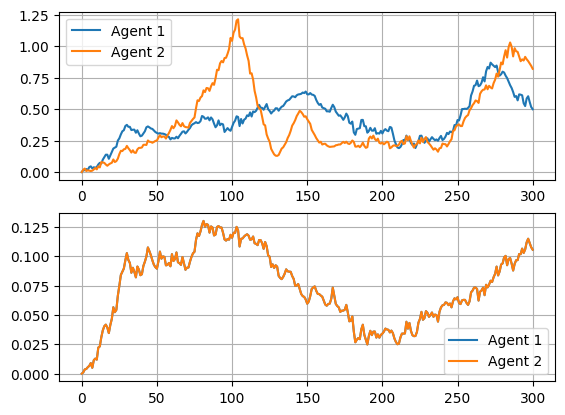

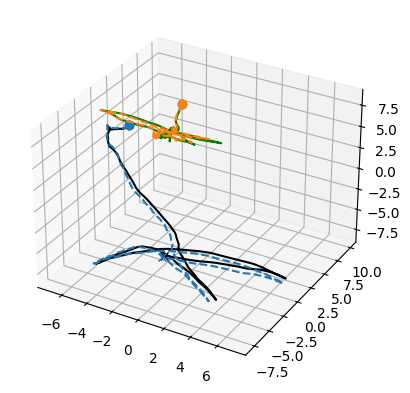

In [10]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor*sampling_factor) == 0:
        dx = np.vstack([dx_0.reshape(1, *dx_0.shape), dx_1.reshape(1, *dx_1.shape)])
        q_odom = np.vstack([q_0.reshape(1, *q_0.shape), q_1.reshape(1, *q_1.shape)])
        d = np.linalg.norm(drone_1.x_real[i] - drone_0.x_real[i]) + np.random.randn(1)[0] * sigma_uwb

        d = np.array([[0, d], [0, 0]])
        NLS.update(d, dx, q_odom)

        nls_logger.log_data(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))

nls_logger.plot_self()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
NLS.agents[0].set_plotting_settings(color="green")
NLS.agents[0].plot_real_position(ax)
NLS.agents[1].set_plotting_settings(color="black")
NLS.agents[1].plot_real_position(ax)
nls_logger.plot_corrected_estimated_trajectory(ax, color="tab:blue", linestyle="--")
nls_logger.plot_corrected_estimated_trajectory(ax, agent=1, color="tab:orange", linestyle="--")
#TODO: add legend and labels

plt.show()

### QCQP
It is important to note you need a Gurboi license to run this code.
#### Setting up the QCQP

In [19]:
from Code.BaseLines.QCQP import QCQP
from Code.DataLoggers.QCQP_DataLogger import QCQP_Log

qcqp = QCQP(horizon=1000,  sigma_uwb=sigma_uwb)
qcqp_log = QCQP_Log(qcqp, drone_0, drone_1)

#### Running the QCQP simulation

Simulation step:  1  / 3000
Simulation step:  2  / 3000
Simulation step:  3  / 3000
Simulation step:  4  / 3000
Simulation step:  5  / 3000
Simulation step:  6  / 3000
Simulation step:  7  / 3000
Simulation step:  8  / 3000
Simulation step:  9  / 3000
Simulation step:  10  / 3000
Simulation step:  11  / 3000
Simulation step:  12  / 3000
Simulation step:  13  / 3000
Simulation step:  14  / 3000
Simulation step:  15  / 3000
Simulation step:  16  / 3000
Simulation step:  17  / 3000
Simulation step:  18  / 3000
Simulation step:  19  / 3000
Simulation step:  20  / 3000
Simulation step:  21  / 3000
Simulation step:  22  / 3000
Simulation step:  23  / 3000
Simulation step:  24  / 3000
Simulation step:  25  / 3000
Simulation step:  26  / 3000
Simulation step:  27  / 3000
Simulation step:  28  / 3000
Simulation step:  29  / 3000
Simulation step:  30  / 3000
Simulation step:  31  / 3000
Simulation step:  32  / 3000
Simulation step:  33  / 3000
Simulation step:  34  / 3000
Simulation step:  35  /

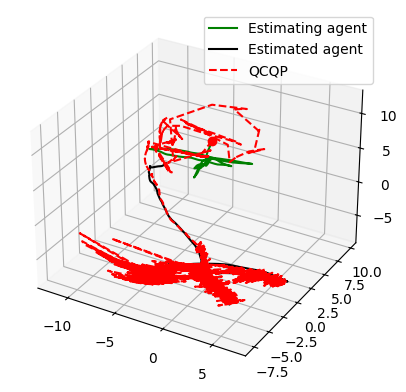

In [20]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor) == 0:
        d = np.linalg.norm(drone_1.x_real[i] - drone_0.x_real[i]) + np.random.randn(1)[0] * sigma_uwb
        qcqp.update(dx_0, dx_1, d)

        qcqp_log.log(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
drone_0.plot_trajectory(ax= ax, color="green", label="Estimating agent")
drone_1.plot_trajectory(ax= ax, color="k", label="Estimated agent")
# self.drone.plot_slam_position(ax=ax, color="k", linestyle="--")
# self.host.plot_slam_position(ax=ax, color="green", linestyle="--")
qcqp_log.plot_corrected_estimated_trajectory(ax=ax, color="r", linestyle="--", marker="", label="QCQP")
plt.legend()
plt.show()


### Algebraic


#### Setting up the Algebraic method

In [27]:
from Code.BaseLines.AlgebraicMethod4DoF import AlgebraicMethod4DoF
from Code.BaseLines.AlgebraicMethod4DoF import Algebraic4DoF_Logger

AM0 = AlgebraicMethod4DoF(startMeasurement[0], sigma_uwb=sigma_uwb, x_ha=pose_drone_0)
AM0.horizon = 100
alg_log = Algebraic4DoF_Logger(alg_solver=AM0, host=drone_0, connect=drone_1)

#### Running the Algebraic method simulation

Simulation step:  1  / 3000
Simulation step:  2  / 3000
Simulation step:  3  / 3000
Simulation step:  4  / 3000
Simulation step:  5  / 3000
Simulation step:  6  / 3000
Simulation step:  7  / 3000
Simulation step:  8  / 3000
Simulation step:  9  / 3000
Simulation step:  10  / 3000
Simulation step:  11  / 3000
Simulation step:  12  / 3000
Simulation step:  13  / 3000
Simulation step:  14  / 3000
Simulation step:  15  / 3000
Simulation step:  16  / 3000
Simulation step:  17  / 3000
Simulation step:  18  / 3000
Simulation step:  19  / 3000
Simulation step:  20  / 3000
Simulation step:  21  / 3000
Simulation step:  22  / 3000
Simulation step:  23  / 3000
Simulation step:  24  / 3000
Simulation step:  25  / 3000
Simulation step:  26  / 3000
Simulation step:  27  / 3000
Simulation step:  28  / 3000
Simulation step:  29  / 3000
Simulation step:  30  / 3000
Simulation step:  31  / 3000
Simulation step:  32  / 3000
Simulation step:  33  / 3000
Simulation step:  34  / 3000
Simulation step:  35  /

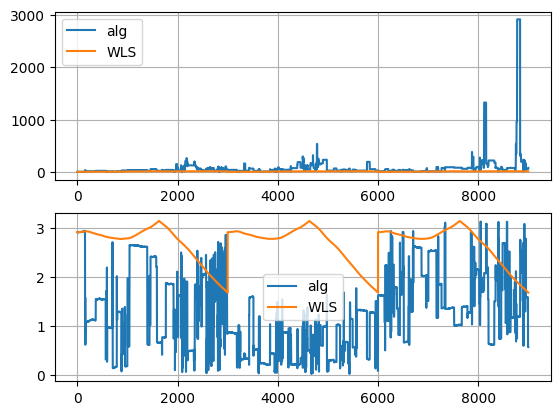

In [30]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor) == 0:
        d = np.linalg.norm(drone_1.x_real[i] - drone_0.x_real[i]) + np.random.randn(1)[0] * sigma_uwb
        AM0.get_update(d=d, dx_ha=dx_0, dx_ca=dx_1, q_ha=q_0, q_ca=q_1)

        alg_log.log(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))

# , ax = plt.subplots(2, 1)

alg_log.plot_self()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# drone_0.plot_trajectory(ax=ax, color="green", label="Estimating agent")
# drone_1.plot_trajectory(ax=ax, color="k", label="Estimated agent")
# # self.drone.plot_slam_position(ax=ax, color="k", linestyle="--")
# # self.host.plot_slam_position(ax=ax, color="green", linestyle="--")
# qcqp_log.plot_corrected_estimated_trajectory(ax=ax, color="r", linestyle="--", marker="", label="QCQP")
# plt.legend()
plt.show()


### Running analysis

## Running in ROS environment